In [79]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# dataset used: https://www.kaggle.com/fanconic/skin-cancer-malignant-vs-benign

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt


In [71]:
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        'skin/train/',
        classes = ['benign', 'malignant'],
        target_size=(200, 200),
        batch_size=329,
        # Use binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        'skin/test/',
        classes = ['benign', 'malignant'],
        target_size=(200, 200),
        batch_size=82,
        # Use binary labels
        class_mode='binary',
        shuffle=False)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape=(220, 220, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation ='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (200,200,3)), 
#                                     tf.keras.layers.Dense(128, activation=tf.nn.relu), 
#                                     tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])
model.summary()

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 218, 218, 16)      448       
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 109, 109, 16)      0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 107, 107, 32)      4640      
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 51, 51, 64)        18496     
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 25, 25, 64)        0         
____________________________________

In [72]:
model.compile(loss='binary_crossentropy',
optimizer='Adam', metrics='accuracy')

In [73]:
history = model.fit_generator(train_generator, steps_per_epoch=8, epochs=10, verbose=1, validation_data=validation_generator, validation_steps=8)

Epoch 1/10
8/8 [==============================] - 35s 4s/step - loss: 0.6955 - accuracy: 0.5353 - val_loss: 0.6669 - val_accuracy: 0.5503
Epoch 2/10
8/8 [==============================] - 37s 5s/step - loss: 0.6450 - accuracy: 0.6138 - val_loss: 0.6261 - val_accuracy: 0.7149
Epoch 3/10
8/8 [==============================] - 30s 4s/step - loss: 0.5503 - accuracy: 0.7401 - val_loss: 0.4946 - val_accuracy: 0.7195
Epoch 4/10
8/8 [==============================] - 30s 4s/step - loss: 0.4940 - accuracy: 0.7565 - val_loss: 0.4678 - val_accuracy: 0.7652
Epoch 5/10
8/8 [==============================] - 28s 4s/step - loss: 0.4550 - accuracy: 0.7782 - val_loss: 0.4495 - val_accuracy: 0.7759
Epoch 6/10
8/8 [==============================] - 28s 3s/step - loss: 0.4807 - accuracy: 0.7657 - val_loss: 0.4356 - val_accuracy: 0.7790
Epoch 7/10
8/8 [==============================] - 28s 3s/step - loss: 0.4797 - accuracy: 0.7558 - val_loss: 0.5106 - val_accuracy: 0.7271
Epoch 8/10
8/8 [==================

In [74]:
model.evaluate(validation_generator)

9/9 [==============================] - 2s 202ms/step - loss: 0.4339 - accuracy: 0.8030


[0.43385910987854004, 0.8030303120613098]

In [77]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)
roc_auc = auc(fpr, tpr)

9/9 [==============================] - 3s 269ms/step


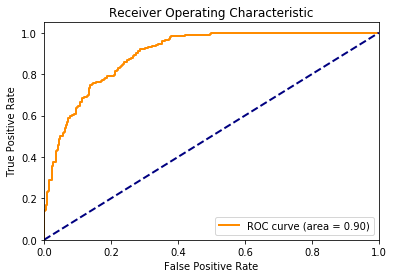

In [80]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()